# Assignment 3: Clustering and Fitting

In this assigment, We are focusing on Co2 emmission (kt) for countries .

Creating 3 clusters.

#Clustering Tools Functions

In [432]:
""" Tools to support clustering: correlation heatmap, normaliser and scale
(cluster centres) back to original scale, check for mismatching entries """


def map_corr(df, size=6):
    """Function creates heatmap of correlation matrix for each pair of
    columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot (in inch)

    The function does not have a plt.show() at the end so that the user
    can savethe figure.
    """

    import matplotlib.pyplot as plt  # ensure pyplot imported

    corr = df.corr()
    plt.figure(figsize=(size, size))
    # fig, ax = plt.subplots()
    plt.matshow(corr, cmap='coolwarm', location="bottom")
    # setting ticks to column names
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

    plt.colorbar()
    # no plt.show() at the end


def scaler(df):
    """ Expects a dataframe and normalises all
        columnsto the 0-1 range. It also returns
        dataframes with minimum and maximum for
        transforming the cluster centres"""

    # Uses the pandas methods
    df_min = df.min()
    df_max = df.max()

    df = (df-df_min) / (df_max - df_min)

    return df, df_min, df_max


def backscale(arr, df_min, df_max):
    """ Expects an array of normalised cluster centres and scales
        it back. Returns numpy array.  """

    # convert to dataframe to enable pandas operations
    minima = df_min.to_numpy()
    maxima = df_max.to_numpy()

    # loop over the "columns" of the numpy array
    for i in range(len(minima)):
        arr[:, i] = arr[:, i] * (maxima[i] - minima[i]) + minima[i]

    return arr


def get_diff_entries(df1, df2, column):
    """ Compares the values of column in df1 and the column with the same
    name in df2. A list of mismatching entries is returned. The list will be
    empty if all entries match. """

    import pandas as pd  # to be sure

    # merge dataframes keeping all rows
    df_out = pd.merge(df1, df2, on=column, how="outer")
    print("total entries", len(df_out))
    # merge keeping only rows in common
    df_in = pd.merge(df1, df2, on=column, how="inner")
    print("entries in common", len(df_in))
    df_in["exists"] = "Y"

    # merge again
    df_merge = pd.merge(df_out, df_in, on=column, how="outer")

    # extract columns without "Y" in exists
    df_diff = df_merge[(df_merge["exists"] != "Y")]
    diff_list = df_diff[column].to_list()

    return diff_list



#Error Ranges functions


In [433]:
"""
Module errors. Contains:
error_prop Calculates the error range caused by the uncertainty of the fit
    parameters. Covariances are taken into account.
cover_to_corr: Converts covariance matrix into correlation matrix.
"""


import numpy as np


def error_prop(x, func, parameter, covar):
    """
    Calculates 1 sigma error ranges for number or array. It uses error
    propagation with variances and covariances taken from the covar matrix.
    Derivatives are calculated numerically.

    """

    # initiate sigma the same shape as parameter

    var = np.zeros_like(x)   # initialise variance vektor
    # Nested loop over all combinations of the parameters
    for i in range(len(parameter)):
        # derivative with respect to the ith parameter
        deriv1 = deriv(x, func, parameter, i)

        for j in range(len(parameter)):
            # derivative with respct to the jth parameter
            deriv2 = deriv(x, func, parameter, j)



            # multiplied with the i-jth covariance
            # variance vektor
            var = var + deriv1*deriv2*covar[i, j]

    sigma = np.sqrt(var)
    return sigma


def deriv(x, func, parameter, ip):
    """
    Calculates numerical derivatives from function
    values at parameter +/- delta.  Parameter is the vector with parameter
    values. ip is the index of the parameter to derive the derivative.

    """

    # print("in", ip, parameter[ip])
    # create vector with zeros and insert delta value for relevant parameter
    # delta is calculated as a small fraction of the parameter value
    scale = 1e-6   # scale factor to calculate the derivative
    delta = np.zeros_like(parameter, dtype=float)
    val = scale * np.abs(parameter[ip])
    delta[ip] = val  #scale * np.abs(parameter[ip])

    diff = 0.5 * (func(x, *parameter+delta) - func(x, *parameter-delta))
    dfdx = diff / val

    return dfdx


def covar_to_corr(covar):
    """ Converts the covariance matrix into a correlation matrix """

    # extract variances from the diagonal and calculate std. dev.
    sigma = np.sqrt(np.diag(covar))
    # construct matrix containing the sigma values
    matrix = np.outer(sigma, sigma)
    # and divide by it
    corr = covar/matrix

    return corr




#**Getting Data from worldbank link**


"https://api.worldbank.org/v2/en/topic/19?downloadformat=excel"



In [434]:
import pandas as pd


In [435]:
excel = pd.ExcelFile("https://api.worldbank.org/v2/en/topic/19?downloadformat=excel")

In [436]:
sheet_names = excel.sheet_names
# Print the sheet names and the number of sheets
print("Sheet names:", sheet_names)
print("Number of sheets:", len(sheet_names))

Sheet names: ['Data', 'Metadata - Countries', 'Metadata - Indicators']
Number of sheets: 3


In [437]:
df = {}
for name in sheet_names:
  df[name] = excel.parse(name)

# extracting header row
rows = df['Data'].iloc[2]
df['Data'] = df['Data'].loc[3:].reset_index(drop=True)

print(rows)


Data Source                       Country Name
World Development Indicators      Country Code
Unnamed: 2                      Indicator Name
Unnamed: 3                      Indicator Code
Unnamed: 4                              1960.0
                                     ...      
Unnamed: 62                             2018.0
Unnamed: 63                             2019.0
Unnamed: 64                             2020.0
Unnamed: 65                             2021.0
Unnamed: 66                             2022.0
Name: 2, Length: 67, dtype: object


**Data Rows**

In [438]:
df['Data'].columns = list(rows)

In [439]:
len(df['Data'])

20216

In [440]:
df['Data'].head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,43.866000,44.052000
1,Aruba,ABW,Urban population,SP.URB.TOTL,27728.000,28330.000000,28764.000000,29157.000000,29505.000000,29802.000000,...,44228.000000,44588.000000,44943.000000,45297.000000,45648.000000,45999.000000,46351.000000,46574.000000,46734.000000,46891.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.147858,1.520329,1.357042,1.186472,1.001576,...,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958,0.342951,0.335381
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.000,55811.000000,56682.000000,57475.000000,58178.000000,58782.000000,...,102880.000000,103594.000000,104257.000000,104874.000000,105439.000000,105962.000000,106442.000000,106585.000000,106537.000000,106445.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.179059,1.548572,1.389337,1.215721,1.032841,...,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.451970,0.134255,-0.045045,-0.086392


**If dropped all rows with any missing values leads to huge amount of Data Loss**

In [441]:
import copy
data = copy.copy(df['Data'])
data.dropna(inplace=True)
len(data)

998

#**EDA**

Following steps are performed

1. Missing Values Analysis <br>
2. Data Distribution <br>
3. Correlation Analysis <br>
4. Outlier Detection <br>
5. Visualizations <br>

---
##1. **Missing Value Analysis** <br>
Total Number of rows of data

In [442]:
import copy
dff = copy.copy(df['Data'])
dff.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,43.866000,44.052000
1,Aruba,ABW,Urban population,SP.URB.TOTL,27728.000,28330.000000,28764.000000,29157.000000,29505.000000,29802.000000,...,44228.000000,44588.000000,44943.000000,45297.000000,45648.000000,45999.000000,46351.000000,46574.000000,46734.000000,46891.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.147858,1.520329,1.357042,1.186472,1.001576,...,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958,0.342951,0.335381
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.000,55811.000000,56682.000000,57475.000000,58178.000000,58782.000000,...,102880.000000,103594.000000,104257.000000,104874.000000,105439.000000,105962.000000,106442.000000,106585.000000,106537.000000,106445.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.179059,1.548572,1.389337,1.215721,1.032841,...,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.451970,0.134255,-0.045045,-0.086392


Total Number of Rows

In [443]:
len(dff)

20216

###**Looking through missing time related Data** <br>

**Remove Empty rows in time data**

In [444]:
# Data frame containing Year columns
year_data = dff.transpose()[4:].transpose()

row_length = len(year_data)
#Remove empty
#Deleting empty rows
dff = dff.dropna(subset=year_data.columns, how='all')
len(dff)

print(f"{row_length - len(dff)} Empty rows removed")
print(len(dff))

3254 Empty rows removed
16962


In [445]:
len(dff)

16962

In [446]:
missing_values = dff.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
Country Name          0
Country Code          0
Indicator Name        0
Indicator Code        0
1960.0            14469
                  ...  
2018.0             8778
2019.0             8612
2020.0             8867
2021.0            11746
2022.0            14197
Length: 67, dtype: int64


In [447]:

sorted_columns = missing_values.sort_values(ascending=False)

# print("Columns with the highest number of missing values:")
print("Column Name \t Missing Values")
for column_name, numbers in sorted_columns.items():
  print(f"{column_name} \t\t {numbers}")

Column Name 	 Missing Values
1960.0 		 14469
2022.0 		 14197
1961.0 		 12889
1962.0 		 12855
1963.0 		 12838
1964.0 		 12797
1965.0 		 12768
1966.0 		 12762
1967.0 		 12757
1968.0 		 12746
1969.0 		 12741
1970.0 		 12201
2021.0 		 11746
1971.0 		 10861
1972.0 		 10842
1973.0 		 10839
1974.0 		 10835
1975.0 		 10783
1976.0 		 10759
1978.0 		 10745
1977.0 		 10742
1979.0 		 10736
1980.0 		 10681
1982.0 		 10620
1981.0 		 10615
1983.0 		 10602
1984.0 		 10588
1985.0 		 10555
1986.0 		 10540
1988.0 		 10477
1989.0 		 10471
1987.0 		 10470
2020.0 		 8867
2017.0 		 8803
2018.0 		 8778
2019.0 		 8612
2016.0 		 7098
1991.0 		 5911
2013.0 		 5581
1992.0 		 5527
2014.0 		 5511
1993.0 		 5463
1994.0 		 5378
1997.0 		 5339
1995.0 		 5313
1996.0 		 5306
1998.0 		 5290
1999.0 		 5171
2001.0 		 4968
2002.0 		 4907
2003.0 		 4899
2004.0 		 4744
2012.0 		 4615
2006.0 		 4585
2011.0 		 4578
2007.0 		 4555
2009.0 		 4476
1990.0 		 4377
2008.0 		 4248
2010.0 		 4227
2005.0 		 4187
2015.0 		 4144
2000.0 		



###**We are going to use data from 1991 till 2020 For Analysis**
We can see that data before 1991 has plenty of missing values. Also , 2020 onwards data also has large number of missing values <br> <br>

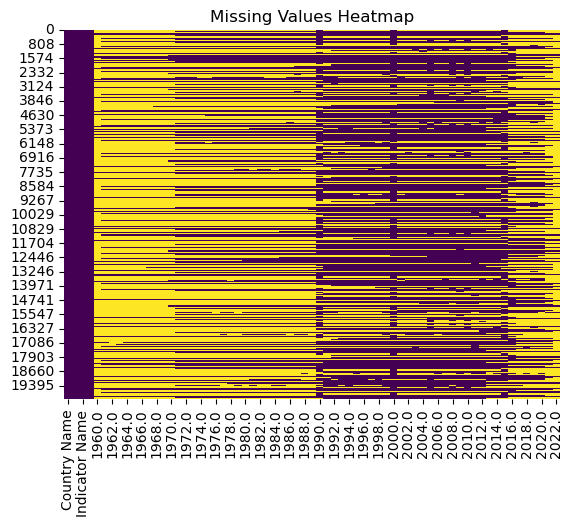

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = dff.iloc[:, 2:]
heatmap_data.set_index('Indicator Name', inplace=True)

sns.heatmap(dff.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [449]:
len(dff)

16962

In [450]:
a = dff.transpose()[4:].transpose()
# range of columns to drop
rr = [float(i) for i in range(1960,1990)] + [2021.0,2022.0]
print(rr)
a = a.drop(columns=rr)

# Non year columns
b = dff.transpose()[:4].transpose()


# Merge all
dff = pd.concat([b,a],axis = 1)




[1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 2021.0, 2022.0]


In [451]:
dff.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.319,50.304,49.998,49.588,49.177,48.767,...,42.94,42.957,42.99,43.041,43.108,43.192,43.293,43.411,43.546,43.697
1,Aruba,ABW,Urban population,SP.URB.TOTL,33066.0,34138.0,35095.0,35882.0,36740.0,37575.0,...,43493.0,43864.0,44228.0,44588.0,44943.0,45297.0,45648.0,45999.0,46351.0,46574.0
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,1.68348,3.190557,2.764754,2.217711,2.36303,2.247286,...,0.662063,0.849393,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958
3,Aruba,ABW,"Population, total",SP.POP.TOTL,65712.0,67864.0,70192.0,72360.0,74710.0,77050.0,...,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,1.712907,3.222415,3.372864,3.041932,3.196029,3.084061,...,0.939356,0.810231,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.45197,0.134255


In [452]:
print(f"Total rows: {len(dff)}")

Total rows: 16962


**Missing Values per Column**

In [453]:
missing_values = dff.isnull().sum()
sorted_columns = missing_values.sort_values(ascending=False)

print("Columns with the highest number of missing values:")
print(sorted_columns)

Columns with the highest number of missing values:
2020.0            8867
2017.0            8803
2018.0            8778
2019.0            8612
2016.0            7098
1991.0            5911
2013.0            5581
1992.0            5527
2014.0            5511
1993.0            5463
1994.0            5378
1997.0            5339
1995.0            5313
1996.0            5306
1998.0            5290
1999.0            5171
2001.0            4968
2002.0            4907
2003.0            4899
2004.0            4744
2012.0            4615
2006.0            4585
2011.0            4578
2007.0            4555
2009.0            4476
1990.0            4377
2008.0            4248
2010.0            4227
2005.0            4187
2015.0            4144
2000.0            2427
Country Code         0
Indicator Code       0
Indicator Name       0
Country Name         0
dtype: int64


**Missing Values by Indicator Name** <br>
Grouping the indicators to find out which indicators have highest number of missing values

In [454]:
from prettytable import PrettyTable
# Group by the 3rd column ('Indicator Name') and count the number of missing values for each indicator
missing_values_count = dff.iloc[:, 2:].groupby(dff.iloc[:, 2]).apply(lambda x: x.isnull().sum(axis=1).sum())

# Sort the indicators by the number of missing values in descending order
sorted_missing_values = missing_values_count.sort_values(ascending=False)


# Display the sorted list
print("Sorted list of indicators with the number of blank entries:")

so = sorted_missing_values.to_dict()

pt = PrettyTable(['Indicator Name', 'Count'])

# # Print the PrettyTable
for key,value in so.items():
  pt.add_row([key, value])

print(pt)


Sorted list of indicators with the number of blank entries:
+--------------------------------------------------------------------------------------------+-------+
|                                       Indicator Name                                       | Count |
+--------------------------------------------------------------------------------------------+-------+
| Urban population living in areas where elevation is below 5 meters (% of total population) |  7364 |
| Rural population living in areas where elevation is below 5 meters (% of total population) |  7364 |
|                 Urban land area where elevation is below 5 meters (sq. km)                 |  7364 |
|          Urban land area where elevation is below 5 meters (% of total land area)          |  7364 |
|             Land area where elevation is below 5 meters (% of total land area)             |  7364 |
|    Population living in areas where elevation is below 5 meters (% of total population)    |  7364 |
|          Ru

### **Decision about Missing values**
 <br>
Now We must check the trends inside the data.

 We have two options either

1. Imputation
2. Drop the values.



elevation below 5 meters data is highly inconsistent. It has 7634 missing values
 Dropping it

In [455]:
threshold_value = sorted_missing_values[0]
elevation_indicators_to_remove = [indicator for indicator, count in sorted_missing_values.items() if count == threshold_value]
# for i in elevation_indicators_to_remove:
#   print(i)
dff = dff[~dff['Indicator Name'].isin(elevation_indicators_to_remove)]


In [456]:
print(len(dff))

14858


In [457]:
missing_values_count = dff.iloc[:, 2:].groupby(dff.iloc[:, 2]).apply(lambda x: x.isnull().sum(axis=1).sum())

# Sort the indicators by the number of missing values in descending order
sorted_missing_values = missing_values_count.sort_values(ascending=False)


# Display the sorted list
print("Sorted list of indicators with the number of blank entries:")

so = sorted_missing_values.to_dict()

pt = PrettyTable(['Indicator Name', 'Count'])

# # Print the PrettyTable
for key,value in so.items():
  pt.add_row([key, value])

print(pt)

Sorted list of indicators with the number of blank entries:
+-------------------------------------------------------------------------------------------+-------+
|                                       Indicator Name                                      | Count |
+-------------------------------------------------------------------------------------------+-------+
|            Terrestrial and marine protected areas (% of total territorial area)           |  6797 |
|                     Terrestrial protected areas (% of total land area)                    |  6796 |
|             Ease of doing business rank (1=most business-friendly regulations)            |  5670 |
|                      Marine protected areas (% of territorial waters)                     |  5484 |
|        Droughts, floods, extreme temperatures (% of population, average 1990-2009)        |  5040 |
|             Prevalence of underweight, weight for age (% of children under 5)             |  4108 |
|                 GHG 

In [458]:
entries_count_per_indicator = (dff.shape[0] * dff.shape[1])/len(sorted_missing_values)
entries_count_per_indicator

7647.5

####**PERCENTAGE OF MISSING VALUES FOR EACH INDICATOR**

In [459]:
# Calculate the number of missing values in each column
missing_percentage_dict = {}

for indicator, count in sorted_missing_values.items():
    total_entries = len(dff)
    missing_percentage = (count / entries_count_per_indicator) * 100
    missing_percentage_dict[indicator] = missing_percentage

pt = PrettyTable(['Indicator ', 'Percentage %'])

# Print or display the missing entries percentage for each indicator
for indicator, percentage in missing_percentage_dict.items():
    pt.add_row([indicator, round(percentage,1)])

print(pt)

+-------------------------------------------------------------------------------------------+--------------+
|                                         Indicator                                         | Percentage % |
+-------------------------------------------------------------------------------------------+--------------+
|            Terrestrial and marine protected areas (% of total territorial area)           |     88.9     |
|                     Terrestrial protected areas (% of total land area)                    |     88.9     |
|             Ease of doing business rank (1=most business-friendly regulations)            |     74.1     |
|                      Marine protected areas (% of territorial waters)                     |     71.7     |
|        Droughts, floods, extreme temperatures (% of population, average 1990-2009)        |     65.9     |
|             Prevalence of underweight, weight for age (% of children under 5)             |     53.7     |
|                 G

####**Removing indicators with more than 33 % missing values**
I have kept the threshold at 33% because I want to keep indicators related to greenhouse gas effect

In [460]:
threshold_percentage = 30.0
indicators_to_remove = [i for i,p in missing_percentage_dict.items() if p > threshold_percentage]

In [461]:
for i in indicators_to_remove:
  print(i)

Terrestrial and marine protected areas (% of total territorial area)
Terrestrial protected areas (% of total land area)
Ease of doing business rank (1=most business-friendly regulations)
Marine protected areas (% of territorial waters)
Droughts, floods, extreme temperatures (% of population, average 1990-2009)
Prevalence of underweight, weight for age (% of children under 5)
GHG net emissions/removals by LUCF (Mt of CO2 equivalent)
HFC gas emissions (thousand metric tons of CO2 equivalent)
PFC gas emissions (thousand metric tons of CO2 equivalent)
SF6 gas emissions (thousand metric tons of CO2 equivalent)
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)
Primary completion rate, total (% of relevant age group)
Agricultural irrigated land (% of total agricultural land)
School enrollment, primary and secondary (gross), gender parity index (GPI)
Disaster risk reduction progress score (1-5 scale; 5=best)
Total greenhouse gas emissions (% change from 1990)


In [462]:
dff = dff[~dff['Indicator Name'].isin(indicators_to_remove)]

In [463]:
dff.shape

(11892, 35)

In [464]:
missing_values_count = dff.iloc[:, 2:].groupby(dff.iloc[:, 2]).apply(lambda x: x.isnull().sum(axis=1).sum())

# Sort the indicators by the number of missing values in descending order
sorted_missing_values = missing_values_count.sort_values(ascending=False)


# Display the sorted list
print("Sorted list of indicators with the number of blank entries:")

so = sorted_missing_values.to_dict()

pt = PrettyTable(['Indicator Name', 'Count'])

# # Print the PrettyTable
for key,value in so.items():
  pt.add_row([key, value])

print(pt)

Sorted list of indicators with the number of blank entries:
+-------------------------------------------------------------------------------------------+-------+
|                                       Indicator Name                                      | Count |
+-------------------------------------------------------------------------------------------+-------+
|                        Nitrous oxide emissions (% change from 1990)                       |  2259 |
|                           Methane emissions (% change from 1990)                          |  2250 |
|      CPIA public sector management and institutions cluster average (1=low to 6=high)     |  2133 |
|                    Other greenhouse gas emissions (% change from 1990)                    |  2107 |
|                        Community health workers (per 1,000 people)                        |  2081 |
|                        Energy use (kg of oil equivalent per capita)                       |  2069 |
|            Energy us

Dropping CPIA since its irrelevant to the goal of Analysis.


### Heat Map

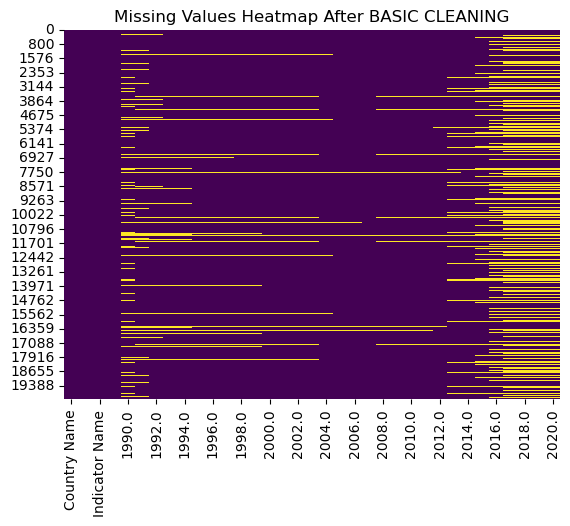

In [465]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = dff.iloc[:, 2:]
heatmap_data.set_index('Indicator Name', inplace=True)

sns.heatmap(dff.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap After BASIC CLEANING')
plt.show()

# plt.figure(figsize=(14, 8))
# sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Indicator Values'})
# plt.title('Heatmap of Indicator Values Across Countries and Years')
# plt.show()
# non_zero = a.columns[(a != 0).all()]
# print(len(a[non_zero]))
# a.head()

# print(a.columns)


# # map_corr(a)
# # # Create a heatmap
# # sns.heatmap(a[non_zero])
# # plt.title("Heatmap")
# # plt.show()


It appears there are still large number of missing values from 2016 to 2020. Identifying these indicators and then Imputing the values.

In [466]:

columns_2016_to_2020 = [2016.0,2017.0,2018.0,2019.0,2020.0]
subset = dff[columns_2016_to_2020]
total_entries_count = subset.shape[0] * subset.shape[1]

subset_df = dff[['Country Name', 'Country Code', 'Indicator Name'] + columns_2016_to_2020]
missing_values_count = subset_df.groupby('Indicator Name').apply(lambda x: x.iloc[:, 3:].isnull().sum(axis=1).sum())

# Sort the indicators by the number of missing values in descending order
sorted_missing_values = missing_values_count.sort_values(ascending=False)



# Display the sorted list
print("Sorted list of indicators with the number of blank entries:")

so = sorted_missing_values.to_dict()

pt = PrettyTable(['Indicator Name', 'Percentage'])
entries_count_per_indicator = (dff.shape[0] * dff.shape[1])/len(sorted_missing_values)

percentage_dict = {}
# # Print the PrettyTable
for key,value in so.items():
  percentage_dict[key] = (value/entries_count_per_indicator)*100
  pt.add_row([key, round((value/entries_count_per_indicator)*100,2)])

print(pt)

Sorted list of indicators with the number of blank entries:
+-------------------------------------------------------------------------------------------+------------+
|                                       Indicator Name                                      | Percentage |
+-------------------------------------------------------------------------------------------+------------+
|                Renewable electricity output (% of total electricity output)               |    16.5    |
|                        Nitrous oxide emissions (% change from 1990)                       |   15.68    |
|                           Methane emissions (% change from 1990)                          |   15.62    |
|                    Other greenhouse gas emissions (% change from 1990)                    |   14.62    |
|                        Energy use (kg of oil equivalent per capita)                       |   13.74    |
|                   CO2 intensity (kg per kg of oil equivalent energy use)          

### Imputing the time Series Data.
Here seaosonal decompose is being as general way for all the remaining unfilled data.

A period of 6 is used to divide the timeseries in 6 seasonal periods each with duration of 5 years

In [467]:
dff.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.319,50.304,49.998,49.588,49.177,48.767,...,42.94,42.957,42.99,43.041,43.108,43.192,43.293,43.411,43.546,43.697
1,Aruba,ABW,Urban population,SP.URB.TOTL,33066.0,34138.0,35095.0,35882.0,36740.0,37575.0,...,43493.0,43864.0,44228.0,44588.0,44943.0,45297.0,45648.0,45999.0,46351.0,46574.0
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,1.68348,3.190557,2.764754,2.217711,2.36303,2.247286,...,0.662063,0.849393,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958
3,Aruba,ABW,"Population, total",SP.POP.TOTL,65712.0,67864.0,70192.0,72360.0,74710.0,77050.0,...,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,1.712907,3.222415,3.372864,3.041932,3.196029,3.084061,...,0.939356,0.810231,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.45197,0.134255


In [468]:
df = copy.copy(dff)

# Extract year columns for interpolation
year_columns = df.columns[4:]

# Convert column names to float
df[year_columns] = df[year_columns].astype(float)

# Interpolate only the year columns
df[year_columns] = df[year_columns].interpolate(method='linear', axis=1)

print("Original DataFrame:")
print(df)

Original DataFrame:
      Country Name Country Code                            Indicator Name  \
0            Aruba          ABW  Urban population (% of total population)   
1            Aruba          ABW                          Urban population   
2            Aruba          ABW        Urban population growth (annual %)   
3            Aruba          ABW                         Population, total   
4            Aruba          ABW              Population growth (annual %)   
...            ...          ...                                       ...   
20206     Zimbabwe          ZWE              Forest area (% of land area)   
20207     Zimbabwe          ZWE                      Forest area (sq. km)   
20213     Zimbabwe          ZWE              Arable land (% of land area)   
20214     Zimbabwe          ZWE        Agricultural land (% of land area)   
20215     Zimbabwe          ZWE                Agricultural land (sq. km)   

          Indicator Code         1990.0         1991.0 

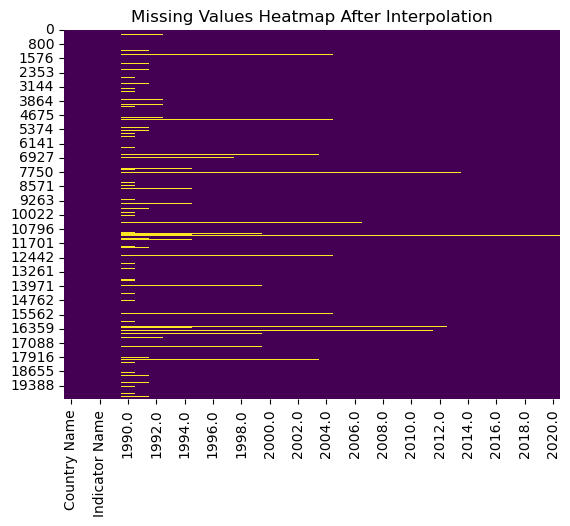

In [469]:
heatmap_data = df.iloc[:, 2:]
heatmap_data.set_index('Indicator Name', inplace=True)

sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap After Interpolation')
plt.show()


In [470]:
df.dropna(inplace=True)

In [471]:
df.shape

(9711, 35)

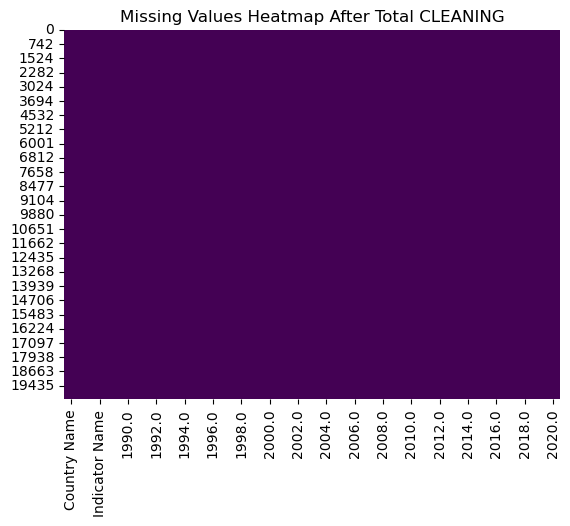

In [472]:
heatmap_data = df.iloc[:, 2:]
heatmap_data.set_index('Indicator Name', inplace=True)

sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap After Total CLEANING')
plt.show()

In [473]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.319000,50.304000,49.998000,49.588000,49.177000,48.767000,...,42.940000,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000
1,Aruba,ABW,Urban population,SP.URB.TOTL,33066.000000,34138.000000,35095.000000,35882.000000,36740.000000,37575.000000,...,43493.000000,43864.000000,44228.000000,44588.000000,44943.000000,45297.000000,45648.000000,45999.000000,46351.000000,46574.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,1.683480,3.190557,2.764754,2.217711,2.363030,2.247286,...,0.662063,0.849393,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958
3,Aruba,ABW,"Population, total",SP.POP.TOTL,65712.000000,67864.000000,70192.000000,72360.000000,74710.000000,77050.000000,...,101288.000000,102112.000000,102880.000000,103594.000000,104257.000000,104874.000000,105439.000000,105962.000000,106442.000000,106585.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,1.712907,3.222415,3.372864,3.041932,3.196029,3.084061,...,0.939356,0.810231,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.451970,0.134255


In [474]:
co2_emission_rows = df[df['Indicator Name'] == 'CO2 emissions (kt)']

In [475]:
co2_emission_rows.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
120,Africa Eastern and Southern,AFE,CO2 emissions (kt),EN.ATM.CO2E.KT,304614.720181,300135.943094,296834.691723,305267.779142,314596.287085,329784.557767,...,525337.889289,546775.865,568547.519,591680.972,576265.992,580219.242,590905.482,598720.9575,610723.50,544952.503
196,Afghanistan,AFG,CO2 emissions (kt),EN.ATM.CO2E.KT,2046.870000,1941.370000,1525.470000,1527.890000,1493.590000,1457.690000,...,11961.890000,10208.130,9402.050,9281.340,10057.590,9294.930,10022.780,10972.3800,11238.83,8709.470
272,Africa Western and Central,AFW,CO2 emissions (kt),EN.ATM.CO2E.KT,97190.345000,110559.933800,121628.003000,114995.869000,106198.491000,116198.614000,...,165498.494900,170350.670,186486.660,196343.630,194363.640,201399.220,200550.900,210618.8900,222990.35,215915.610
348,Angola,AGO,CO2 emissions (kt),EN.ATM.CO2E.KT,6564.200000,6674.500000,6877.300000,9269.700000,11298.230000,12719.480000,...,23865.800000,23868.000,26958.700,29610.500,31648.900,29520.700,25064.800,23637.4000,24382.90,19814.500
424,Albania,ALB,CO2 emissions (kt),EN.ATM.CO2E.KT,6060.500000,4119.600000,2239.300000,2078.400000,2084.700000,1951.100000,...,5136.700000,4541.800,4795.400,5188.000,4797.000,4573.200,5403.700,5316.1000,4993.30,4383.200


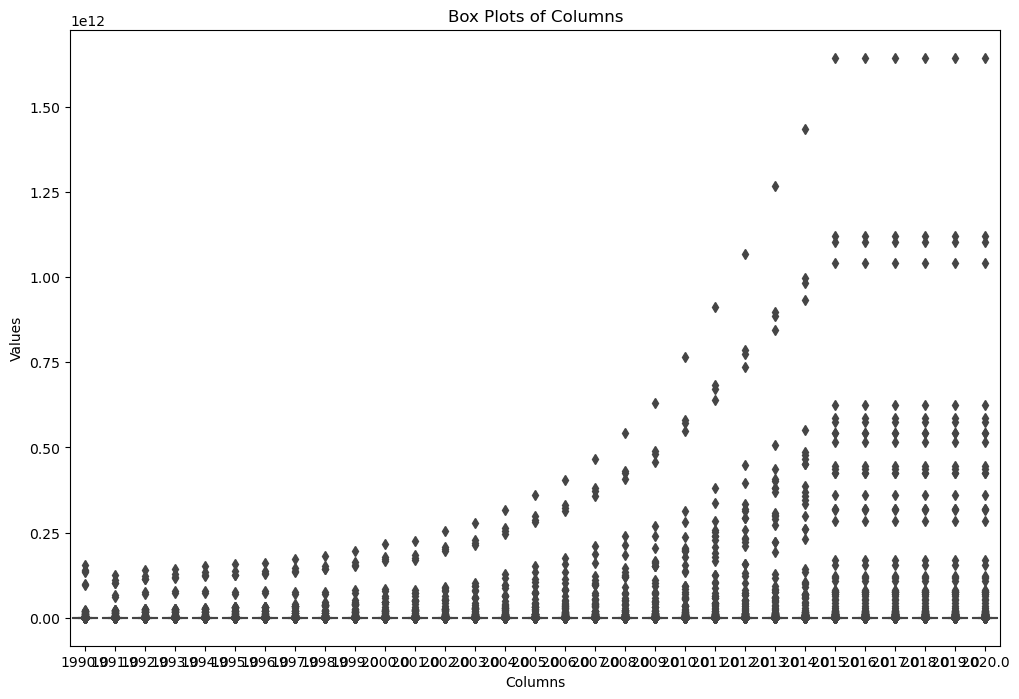

In [476]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xlabel("Columns")
plt.ylabel("Values")
plt.title("Box Plots of Columns")
plt.show()

# Finding Clusters of countries contributing to Co2 emmission in each group of 5 years from 1990 to 2020

In [477]:
co2_emission_rows

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
120,Africa Eastern and Southern,AFE,CO2 emissions (kt),EN.ATM.CO2E.KT,304614.720181,300135.943094,296834.691723,305267.779142,314596.287085,329784.557767,...,525337.889289,546775.865,568547.519,591680.972,576265.992,580219.242,590905.482,598720.9575,610723.50,544952.503
196,Afghanistan,AFG,CO2 emissions (kt),EN.ATM.CO2E.KT,2046.870000,1941.370000,1525.470000,1527.890000,1493.590000,1457.690000,...,11961.890000,10208.130,9402.050,9281.340,10057.590,9294.930,10022.780,10972.3800,11238.83,8709.470
272,Africa Western and Central,AFW,CO2 emissions (kt),EN.ATM.CO2E.KT,97190.345000,110559.933800,121628.003000,114995.869000,106198.491000,116198.614000,...,165498.494900,170350.670,186486.660,196343.630,194363.640,201399.220,200550.900,210618.8900,222990.35,215915.610
348,Angola,AGO,CO2 emissions (kt),EN.ATM.CO2E.KT,6564.200000,6674.500000,6877.300000,9269.700000,11298.230000,12719.480000,...,23865.800000,23868.000,26958.700,29610.500,31648.900,29520.700,25064.800,23637.4000,24382.90,19814.500
424,Albania,ALB,CO2 emissions (kt),EN.ATM.CO2E.KT,6060.500000,4119.600000,2239.300000,2078.400000,2084.700000,1951.100000,...,5136.700000,4541.800,4795.400,5188.000,4797.000,4573.200,5403.700,5316.1000,4993.30,4383.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19804,Samoa,WSM,CO2 emissions (kt),EN.ATM.CO2E.KT,89.000000,97.700000,102.900000,112.500000,103.400000,116.600000,...,196.000000,198.100,196.700,207.300,232.300,246.700,255.200,248.7000,278.70,206.500
19956,"Yemen, Rep.",YEM,CO2 emissions (kt),EN.ATM.CO2E.KT,6642.300000,8498.500000,9130.000000,8552.300000,9339.600000,10531.700000,...,22950.100000,21012.500,27825.000,27429.900,13552.200,10035.200,9682.200,11349.8000,11194.80,9960.100
20032,South Africa,ZAF,CO2 emissions (kt),EN.ATM.CO2E.KT,247614.700000,242286.000000,238780.600000,246445.900000,252088.500000,264251.500000,...,409480.300000,427001.700,437261.700,448298.100,425063.100,425682.900,435214.500,439644.6000,446626.00,393241.600
20108,Zambia,ZMB,CO2 emissions (kt),EN.ATM.CO2E.KT,2740.800000,2876.200000,2848.000000,2514.400000,2143.800000,2129.500000,...,3050.700000,4030.300,4238.600,4686.000,4956.600,5315.300,6810.700,7857.2000,7615.70,7607.100


In [478]:
co2_emissions = df[df['Indicator Name'] == 'CO2 emissions (kt)'].iloc[:, 4:]

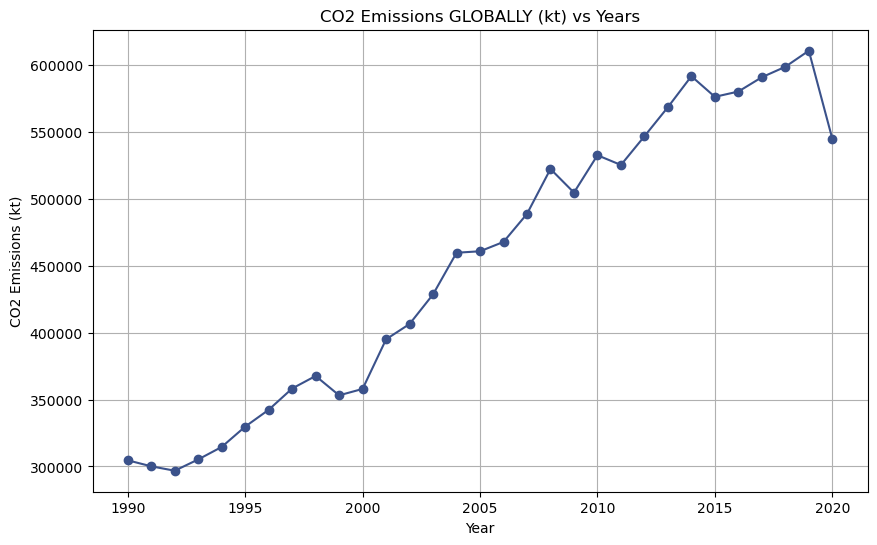

In [479]:
co2_emissions = df[df['Indicator Name'] == 'CO2 emissions (kt)'].iloc[:, 4:]
# Extract years and values for plotting
years = co2_emissions.columns.astype(float)
values = co2_emissions.iloc[0].values.astype(float)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', linestyle='-')
plt.title('CO2 Emissions GLOBALLY (kt) vs Years')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.grid(True)
plt.show()



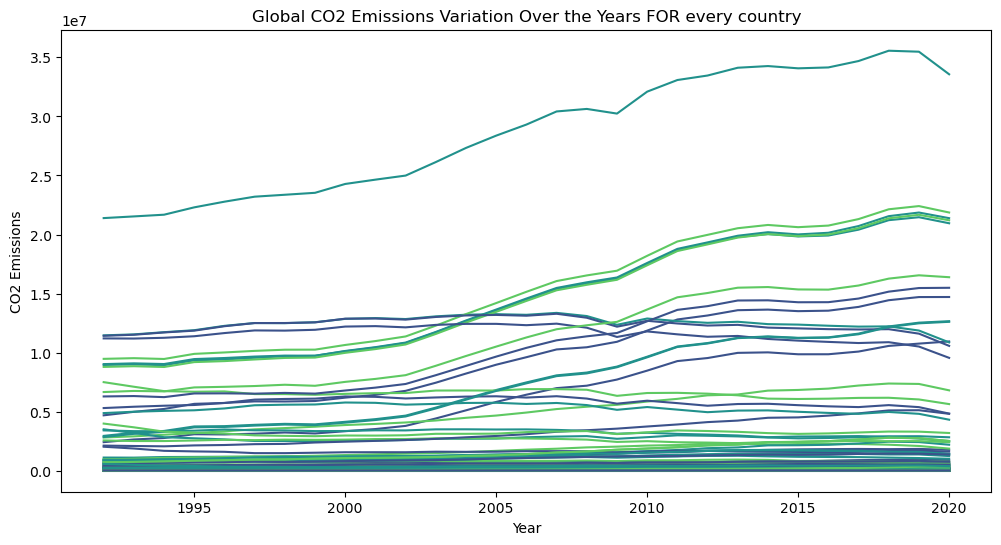

In [480]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot variation graphs for CO2 emissions
for index, row in co2_emissions.iterrows():
    plt.plot(co2_emissions.columns[2:], row.values[2:], label=f'Country {index}')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('Global CO2 Emissions Variation Over the Years FOR every country')

# Show the plot
plt.show()

In [481]:
co2_emissions_2 = df[df['Indicator Name'] == 'CO2 emissions (kt)'].iloc[:, 1:]
co2_emissions_2 = co2_emissions_2.drop(['Indicator Name','Indicator Code' ],axis =1)

In [482]:
co2_emissions_2.head()

,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
120,AFE,304614.720181,300135.943094,296834.691723,305267.779142,314596.287085,329784.557767,342368.178325,358278.381587,367651.937441,...,525337.889289,546775.865,568547.519,591680.972,576265.992,580219.242,590905.482,598720.9575,610723.50,544952.503
196,AFG,2046.870000,1941.370000,1525.470000,1527.890000,1493.590000,1457.690000,1407.300000,1344.100000,1318.000000,...,11961.890000,10208.130,9402.050,9281.340,10057.590,9294.930,10022.780,10972.3800,11238.83,8709.470
272,AFW,97190.345000,110559.933800,121628.003000,114995.869000,106198.491000,116198.614000,134252.745000,134320.486000,129455.595000,...,165498.494900,170350.670,186486.660,196343.630,194363.640,201399.220,200550.900,210618.8900,222990.35,215915.610
348,AGO,6564.200000,6674.500000,6877.300000,9269.700000,11298.230000,12719.480000,15442.400000,16154.900000,16767.900000,...,23865.800000,23868.000,26958.700,29610.500,31648.900,29520.700,25064.800,23637.4000,24382.90,19814.500
424,ALB,6060.500000,4119.600000,2239.300000,2078.400000,2084.700000,1951.100000,1968.000000,1479.160000,1804.550000,...,5136.700000,4541.800,4795.400,5188.000,4797.000,4573.200,5403.700,5316.1000,4993.30,4383.200


In [483]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.319000,50.304000,49.998000,49.588000,49.177000,48.767000,...,42.940000,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000
1,Aruba,ABW,Urban population,SP.URB.TOTL,33066.000000,34138.000000,35095.000000,35882.000000,36740.000000,37575.000000,...,43493.000000,43864.000000,44228.000000,44588.000000,44943.000000,45297.000000,45648.000000,45999.000000,46351.000000,46574.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,1.683480,3.190557,2.764754,2.217711,2.363030,2.247286,...,0.662063,0.849393,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958
3,Aruba,ABW,"Population, total",SP.POP.TOTL,65712.000000,67864.000000,70192.000000,72360.000000,74710.000000,77050.000000,...,101288.000000,102112.000000,102880.000000,103594.000000,104257.000000,104874.000000,105439.000000,105962.000000,106442.000000,106585.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,1.712907,3.222415,3.372864,3.041932,3.196029,3.084061,...,0.939356,0.810231,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.451970,0.134255


In [484]:
year_columns = df.columns[1:]
global_emissions_sum = df[year_columns].sum(axis=0)
global_emissions_sum

Country Code      ABWABWABWABWABWABWABWABWABWABWABWABWABWABWABWA...
Indicator Name    Urban population (% of total population)Urban ...
Indicator Code    SP.URB.TOTL.IN.ZSSP.URB.TOTLSP.URB.GROWSP.POP....
1990.0                                          1159419055217.78833
1991.0                                          989726489319.921875
1992.0                                         1090547210743.405029
1993.0                                         1128062544378.737305
1994.0                                         1188949815857.724121
1995.0                                          1254999331260.85791
1996.0                                         1287122353521.543945
1997.0                                         1370476198546.536133
1998.0                                         1444880468146.015137
1999.0                                          1572748330394.99292
2000.0                                         1742810636581.849121
2001.0                                         1

In [485]:
# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'Year': global_emissions_sum.index,
    'Global CO2 Emissions': global_emissions_sum.values
})

In [486]:
1990.0 in global_emissions_sum.index

True

In [487]:
# making a 2d list of period
import numpy as np
periods = [float(i) for i  in range(1991,2021)]
periods = np.array(periods).reshape(-1,5)
periods

array([[1991., 1992., 1993., 1994., 1995.],
       [1996., 1997., 1998., 1999., 2000.],
       [2001., 2002., 2003., 2004., 2005.],
       [2006., 2007., 2008., 2009., 2010.],
       [2011., 2012., 2013., 2014., 2015.],
       [2016., 2017., 2018., 2019., 2020.]])

In [488]:
result_df.set_index("Year", inplace=True)

In [489]:
avg = []
for period in periods:
  sum = 0
  for year in period:
    sum += result_df.T[year]
  avg.append(float(sum/5))



C:\Users\HP\AppData\Local\Temp\ipykernel_18088\4218647250.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg.append(float(sum/5))
C:\Users\HP\AppData\Local\Temp\ipykernel_18088\4218647250.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg.append(float(sum/5))
C:\Users\HP\AppData\Local\Temp\ipykernel_18088\4218647250.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg.append(float(sum/5))
C:\Users\HP\AppData\Local\Temp\ipykernel_18088\4218647250.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg.append(float(sum/5))
C:\Users\HP\AppData\Local\Temp\ipykernel_18088\4218647250.py:6: 

In [490]:
periods = [float(i) for i in range(1993,2020,5)]

In [491]:
periods

[1993.0, 1998.0, 2003.0, 2008.0, 2013.0, 2018.0]

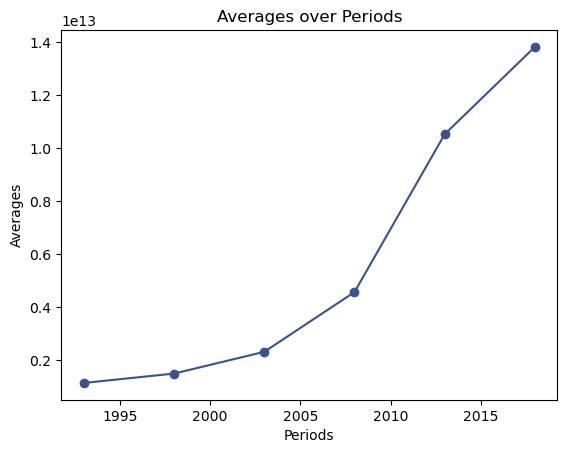

In [492]:
# Plotting
plt.plot(periods, avg, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Periods')
plt.ylabel('Averages')
plt.title('Averages over Periods')

# Display the plot
plt.show()

## **China Co2 emissions**

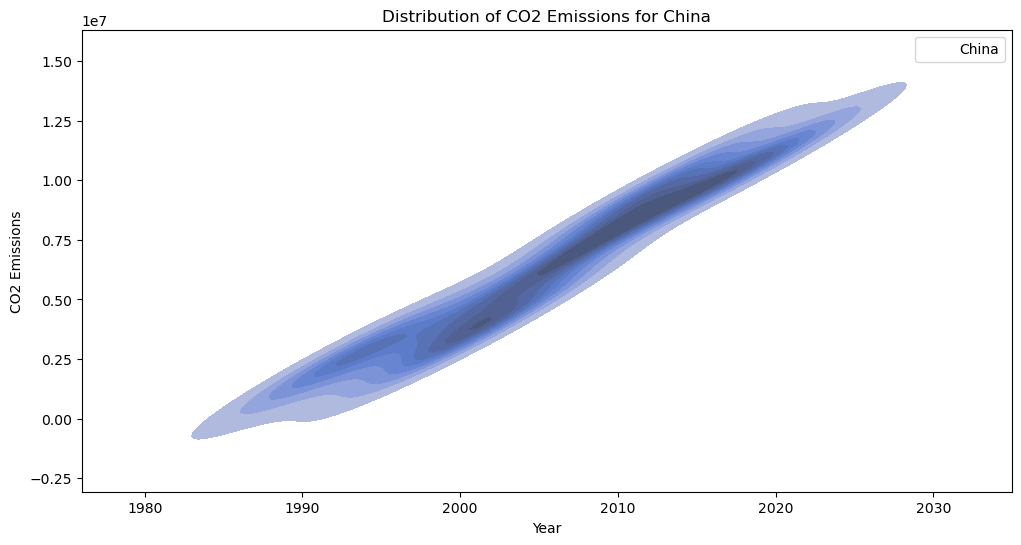

In [493]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df = co2_emissions_2

china_data = df[df['Country Code'] == 'CHN'].iloc[:, 2:]

melted_data = pd.melt(china_data, var_name='Year', value_name='CO2 Emissions')

# Plot distribution graph
sns.kdeplot(melted_data, x='Year', y='CO2 Emissions', fill=True, label='China')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('Distribution of CO2 Emissions for China')

# Display legend
plt.legend()

# Show the plot
plt.show()

### US CO2 Emmission

In [494]:
# Line plot
usa_data = df[df['Country Code'] == 'USA'].iloc[:, 2:]


In [495]:
us_co2_data = pd.Series(usa_data.values[0], index=usa_data.columns)

In [496]:
years = list(map(float, us_co2_data.index))


In [497]:
years  = [i for i in range(1990,2020)]

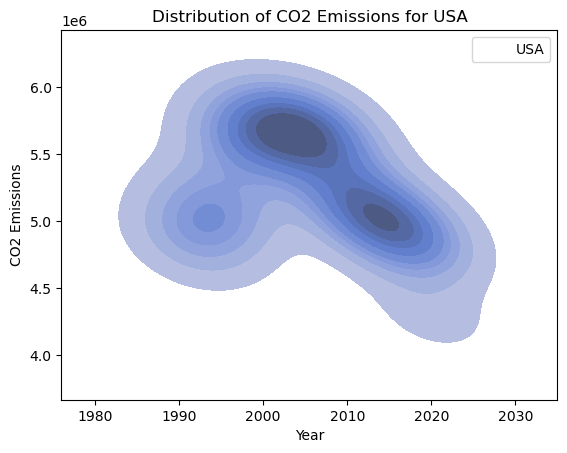

In [498]:

usa_data = df[df['Country Code'] == 'USA'].iloc[:, 2:]

melted_data = pd.melt(usa_data, var_name='Year', value_name='CO2 Emissions')

# Plot distribution graph
sns.kdeplot(melted_data, x='Year', y='CO2 Emissions', fill=True, label='USA')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('Distribution of CO2 Emissions for USA')

# Display legend
plt.legend()

# Show the plot
plt.show()

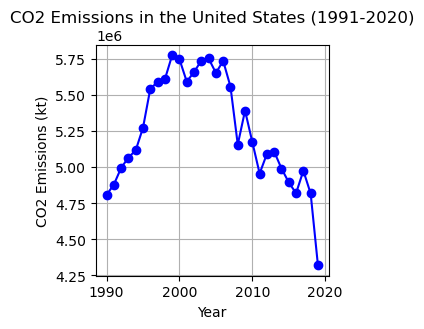

In [499]:

plt.figure(figsize=(3, 3))
plt.plot(years, us_co2_data, marker='o', linestyle='-', color='b')
plt.title('CO2 Emissions in the United States (1991-2020)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kt)')
plt.grid(True)
plt.show()

K-means clustering appears suitable

In [500]:
df = dff.copy()

In [501]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Indicator Code'] = label_encoder.fit_transform(df['Indicator Code'])

In [502]:
df['Country Code'] = label_encoder.fit_transform(df['Country Code'])
df = df.drop(['Country Name', 'Indicator Name'], axis=1)

In [503]:
co2_emission_rows
co2_emission_rows['Country Code'] = label_encoder.fit_transform(co2_emission_rows['Country Code'])
co2_emission_rows = co2_emission_rows.drop(['Country Name', 'Indicator Name'], axis=1)

In [504]:
co2_emission_rows = co2_emission_rows.drop([ 'Indicator Code'], axis=1)

In [505]:
co2_emission_rows.head()

,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
120,0,304614.720181,300135.943094,296834.691723,305267.779142,314596.287085,329784.557767,342368.178325,358278.381587,367651.937441,...,525337.889289,546775.865,568547.519,591680.972,576265.992,580219.242,590905.482,598720.9575,610723.50,544952.503
196,1,2046.870000,1941.370000,1525.470000,1527.890000,1493.590000,1457.690000,1407.300000,1344.100000,1318.000000,...,11961.890000,10208.130,9402.050,9281.340,10057.590,9294.930,10022.780,10972.3800,11238.83,8709.470
272,2,97190.345000,110559.933800,121628.003000,114995.869000,106198.491000,116198.614000,134252.745000,134320.486000,129455.595000,...,165498.494900,170350.670,186486.660,196343.630,194363.640,201399.220,200550.900,210618.8900,222990.35,215915.610
348,3,6564.200000,6674.500000,6877.300000,9269.700000,11298.230000,12719.480000,15442.400000,16154.900000,16767.900000,...,23865.800000,23868.000,26958.700,29610.500,31648.900,29520.700,25064.800,23637.4000,24382.90,19814.500
424,4,6060.500000,4119.600000,2239.300000,2078.400000,2084.700000,1951.100000,1968.000000,1479.160000,1804.550000,...,5136.700000,4541.800,4795.400,5188.000,4797.000,4573.200,5403.700,5316.1000,4993.30,4383.200


### STANDARD SCALING

In [506]:
dfco2, df_min, df_max = scaler(co2_emission_rows)


In [507]:
dfco2.head()

,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
120,0.000000,0.014312,0.013999,0.013877,0.014178,0.014513,0.014789,0.015030,0.015441,0.015735,...,0.015881,0.016341,0.016663,0.017269,0.016914,0.016992,0.017035,0.016836,0.017214,0.016235
196,0.004219,0.000096,0.000091,0.000071,0.000071,0.000069,0.000065,0.000062,0.000058,0.000056,...,0.000361,0.000305,0.000275,0.000271,0.000295,0.000272,0.000289,0.000308,0.000317,0.000259
272,0.008439,0.004566,0.005157,0.005686,0.005341,0.004899,0.005211,0.005894,0.005789,0.005540,...,0.005003,0.005091,0.005465,0.005731,0.005705,0.005898,0.005781,0.005923,0.006285,0.006432
348,0.012658,0.000308,0.000311,0.000322,0.000431,0.000521,0.000570,0.000678,0.000696,0.000718,...,0.000721,0.000713,0.000790,0.000864,0.000929,0.000864,0.000722,0.000664,0.000687,0.000590
424,0.016878,0.000285,0.000192,0.000105,0.000097,0.000096,0.000087,0.000086,0.000064,0.000077,...,0.000155,0.000135,0.000140,0.000151,0.000141,0.000134,0.000156,0.000149,0.000140,0.000130


Finding Clusters of countries for CO2 emmissions

In [508]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

columns_to_cluster = co2_emission_rows.columns[1:]
data_to_cluster = co2_emission_rows[columns_to_cluster]

# Use StandardScaler to scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
co2_emission_rows['Cluster'] = kmeans.fit_predict(data_to_cluster)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [509]:
co2_emission_rows.shape

(238, 33)

In [510]:
# Access the original data points for each cluster
cluster_assignments = co2_emission_rows[['Country Code', 'Cluster']]
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Merge the original data with cluster assignments
result_df = pd.merge(cluster_assignments, co2_emission_rows, on='Country Code')

result_df = result_df.drop('Cluster_x', axis=1)

for cluster in range(num_clusters):
    cluster_data = result_df[result_df['Cluster_y'] == cluster]
    print(f"\nCluster {cluster + 1}:\n")
    print(cluster_data)


Cluster 1:

     Country Code         1990.0         1991.0         1992.0         1993.0  \
0               0  304614.720181  300135.943094  296834.691723  305267.779142   
1               1    2046.870000    1941.370000    1525.470000    1527.890000   
2               2   97190.345000  110559.933800  121628.003000  114995.869000   
3               3    6564.200000    6674.500000    6877.300000    9269.700000   
4               4    6060.500000    4119.600000    2239.300000    2078.400000   
..            ...            ...            ...            ...            ...   
233           233      89.000000      97.700000     102.900000     112.500000   
234           234    6642.300000    8498.500000    9130.000000    8552.300000   
235           235  247614.700000  242286.000000  238780.600000  246445.900000   
236           236    2740.800000    2876.200000    2848.000000    2514.400000   
237           237   16535.500000   18301.000000   18469.600000   17075.600000   

            19

In [511]:
result_df.head()

,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,Cluster_y
0,0,304614.720181,300135.943094,296834.691723,305267.779142,314596.287085,329784.557767,342368.178325,358278.381587,367651.937441,...,546775.865,568547.519,591680.972,576265.992,580219.242,590905.482,598720.9575,610723.50,544952.503,0
1,1,2046.870000,1941.370000,1525.470000,1527.890000,1493.590000,1457.690000,1407.300000,1344.100000,1318.000000,...,10208.130,9402.050,9281.340,10057.590,9294.930,10022.780,10972.3800,11238.83,8709.470,0
2,2,97190.345000,110559.933800,121628.003000,114995.869000,106198.491000,116198.614000,134252.745000,134320.486000,129455.595000,...,170350.670,186486.660,196343.630,194363.640,201399.220,200550.900,210618.8900,222990.35,215915.610,0
3,3,6564.200000,6674.500000,6877.300000,9269.700000,11298.230000,12719.480000,15442.400000,16154.900000,16767.900000,...,23868.000,26958.700,29610.500,31648.900,29520.700,25064.800,23637.4000,24382.90,19814.500,0
4,4,6060.500000,4119.600000,2239.300000,2078.400000,2084.700000,1951.100000,1968.000000,1479.160000,1804.550000,...,4541.800,4795.400,5188.000,4797.000,4573.200,5403.700,5316.1000,4993.30,4383.200,0


C:\Users\HP\AppData\Local\Temp\ipykernel_18088\3277249515.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Year', y='CO2 Emissions', hue='Cluster_y', data=melted_df, ci=None, marker='o', markersize=4)


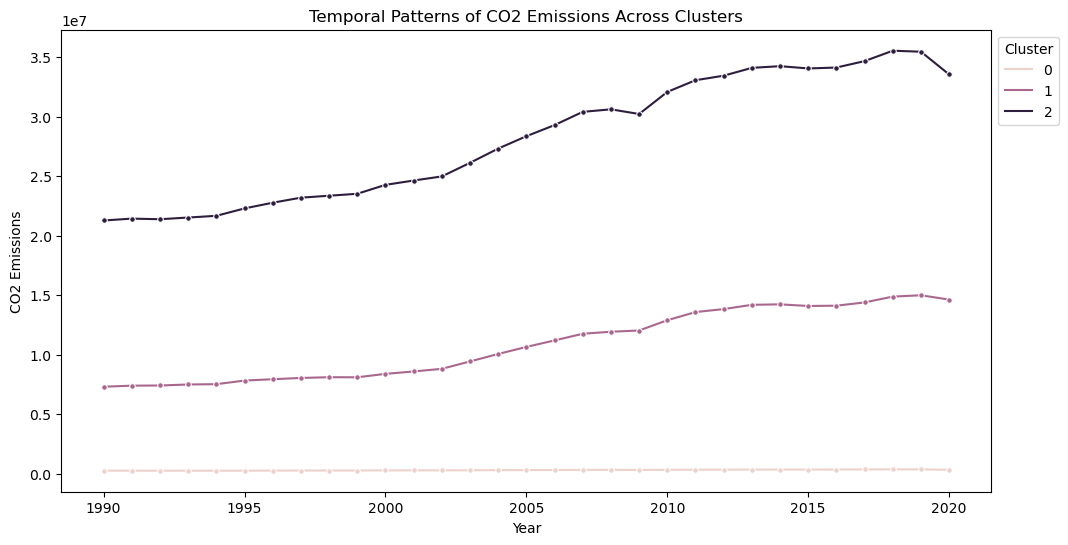

In [512]:
melted_df = pd.melt(result_df, id_vars=['Country Code', 'Cluster_y'], var_name='Year', value_name='CO2 Emissions')

# Convert 'Year' to numeric (assuming it's in string format)
melted_df['Year'] = pd.to_numeric(melted_df['Year'], errors='coerce')

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_palette("viridis", num_clusters)

# Plot trends for each cluster
sns.lineplot(x='Year', y='CO2 Emissions', hue='Cluster_y', data=melted_df, ci=None, marker='o', markersize=4)
plt.title('Temporal Patterns of CO2 Emissions Across Clusters')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))


In [513]:
print(co2_emission_rows.head())

print("Head of result_df:")
print(result_df.head())

     Country Code         1990.0         1991.0         1992.0         1993.0  \
120             0  304614.720181  300135.943094  296834.691723  305267.779142   
196             1    2046.870000    1941.370000    1525.470000    1527.890000   
272             2   97190.345000  110559.933800  121628.003000  114995.869000   
348             3    6564.200000    6674.500000    6877.300000    9269.700000   
424             4    6060.500000    4119.600000    2239.300000    2078.400000   

            1994.0         1995.0         1996.0         1997.0  \
120  314596.287085  329784.557767  342368.178325  358278.381587   
196    1493.590000    1457.690000    1407.300000    1344.100000   
272  106198.491000  116198.614000  134252.745000  134320.486000   
348   11298.230000   12719.480000   15442.400000   16154.900000   
424    2084.700000    1951.100000    1968.000000    1479.160000   

            1998.0  ...      2012.0      2013.0      2014.0      2015.0  \
120  367651.937441  ...  546775.865

# Fitting Curve TASK 2

## Data Preparation

Using GDP Per Capita and Co2 per $ of Capita. Making a predictive model that uses GDP Per Capita to estimate Carbon foot print of a country

In [514]:
co2_per_gdp_df = dff[dff['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']
co2_per_gdp_df.dropna(inplace=True)
co2_per_gdp_df = co2_per_gdp_df.drop(['Indicator Name', 'Indicator Code', 'Country Name'],axis =1)
co2_per_gdp_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_18088\245307156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_per_gdp_df.dropna(inplace=True)


,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
116,AFE,0.54036,0.514329,0.506853,0.50994,0.504869,0.496166,0.479418,0.472672,0.470917,...,0.296043,0.307801,0.299718,0.291419,0.273837,0.261377,0.256064,0.246607,0.241604,0.218652
268,AFW,0.268747,0.291992,0.30623,0.285769,0.258556,0.271225,0.293929,0.27702,0.254847,...,0.122033,0.118883,0.121843,0.119054,0.116555,0.119729,0.114726,0.114211,0.114935,0.11073
344,AGO,0.169026,0.164612,0.176117,0.305047,0.359217,0.344433,0.361664,0.346716,0.33992,...,0.146831,0.128237,0.134884,0.13437,0.154684,0.144092,0.114983,0.107302,0.109504,0.09309
420,ALB,0.723223,0.660473,0.378197,0.312976,0.283798,0.229571,0.208429,0.172879,0.19092,...,0.173213,0.148765,0.156693,0.159487,0.142828,0.131642,0.147252,0.137399,0.121428,0.10971
572,ARB,0.417361,0.376658,0.380836,0.389421,0.392677,0.386011,0.375306,0.370491,0.349088,...,0.279649,0.276015,0.276074,0.283946,0.314372,0.320788,0.303181,0.285615,0.279097,0.27603


Fetching GDP DATA per current USD

In [515]:
excel = pd.ExcelFile("https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel")

Converting to numeric

In [516]:
df = excel.parse('Data')
print(df.shape)
df = df.iloc[2:]
df = df.reset_index(drop=True)
df.columns = list(df.iloc[0])

df = df.iloc[1:]
df = df.reset_index(drop=True)

years_to_remove = [float(i) for i in range(1960,1990)] + [2021.0,2022.0]
df = df.drop(['Indicator Name', 'Indicator Code'] + years_to_remove, axis = 1)

# GDP DATA
df.head()

(269, 67)


,Country Name,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,7.648045e+08,8.720670e+08,9.586592e+08,1.083240e+09,1.245810e+09,1.320670e+09,1.379888e+09,1.531844e+09,...,2.637859e+09,2.615208e+09,2.727850e+09,2.790850e+09,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09
1,Africa Eastern and Southern,AFE,2.546735e+11,2.756220e+11,2.402106e+11,2.383531e+11,2.411580e+11,2.708140e+11,2.689929e+11,2.840654e+11,...,9.716675e+11,9.799969e+11,9.863429e+11,1.006992e+12,9.325135e+11,8.900514e+11,1.028394e+12,1.012521e+12,1.006191e+12,9.288802e+11
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.780510e+10,1.990733e+10,2.014642e+10,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10
3,Africa Western and Central,AFW,1.218036e+11,1.279390e+11,1.225760e+11,1.279809e+11,1.331435e+11,2.056871e+11,2.612621e+11,2.743770e+11,...,6.821761e+11,7.377395e+11,8.340970e+11,8.945050e+11,7.692632e+11,6.921149e+11,6.856303e+11,7.681582e+11,8.234056e+11,7.869624e+11
4,Angola,AGO,1.123628e+10,1.040119e+10,8.307827e+09,6.084689e+09,4.438321e+09,5.538749e+09,6.535435e+09,7.675413e+09,...,1.117897e+11,1.280529e+11,1.323391e+11,1.359668e+11,9.049642e+10,5.276162e+10,7.369016e+10,7.945069e+10,7.089796e+10,4.850156e+10


##Cleaning

In [517]:
usa_gdp = df[df['Country Name'] == 'United States']
usa_gdp

,Country Name,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
251,United States,USA,5.963144e+12,6.158129e+12,6.520327e+12,6.858559e+12,7.287236e+12,7.639749e+12,8.073122e+12,8.577554e+12,...,1.559973e+13,1.625397e+13,1.684319e+13,1.755068e+13,1.820602e+13,1.869511e+13,1.947734e+13,2.053306e+13,2.138098e+13,2.106047e+13


In [518]:
years_column_co2 = co2_per_gdp_df.columns[1:]
gdp_column_gdp = df.columns[2:]

co2_per_gdp_df[years_column_co2] = co2_per_gdp_df[years_column_co2].apply(pd.to_numeric, errors='coerce')

df[gdp_column_gdp] = df[gdp_column_gdp].apply(pd.to_numeric, errors='coerce')

In [519]:
co2_per_gdp_df[years_column_co2] = co2_per_gdp_df[years_column_co2].apply(pd.to_numeric, errors='coerce')


In [520]:
gdp_data = df
gdp_data.head()


,Country Name,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,ABW,7.648045e+08,8.720670e+08,9.586592e+08,1.083240e+09,1.245810e+09,1.320670e+09,1.379888e+09,1.531844e+09,...,2.637859e+09,2.615208e+09,2.727850e+09,2.790850e+09,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09
1,Africa Eastern and Southern,AFE,2.546735e+11,2.756220e+11,2.402106e+11,2.383531e+11,2.411580e+11,2.708140e+11,2.689929e+11,2.840654e+11,...,9.716675e+11,9.799969e+11,9.863429e+11,1.006992e+12,9.325135e+11,8.900514e+11,1.028394e+12,1.012521e+12,1.006191e+12,9.288802e+11
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.780510e+10,1.990733e+10,2.014642e+10,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10
3,Africa Western and Central,AFW,1.218036e+11,1.279390e+11,1.225760e+11,1.279809e+11,1.331435e+11,2.056871e+11,2.612621e+11,2.743770e+11,...,6.821761e+11,7.377395e+11,8.340970e+11,8.945050e+11,7.692632e+11,6.921149e+11,6.856303e+11,7.681582e+11,8.234056e+11,7.869624e+11
4,Angola,AGO,1.123628e+10,1.040119e+10,8.307827e+09,6.084689e+09,4.438321e+09,5.538749e+09,6.535435e+09,7.675413e+09,...,1.117897e+11,1.280529e+11,1.323391e+11,1.359668e+11,9.049642e+10,5.276162e+10,7.369016e+10,7.945069e+10,7.089796e+10,4.850156e+10


In [521]:
co2_per_gdp_df.head()

,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
116,AFE,0.540360,0.514329,0.506853,0.509940,0.504869,0.496166,0.479418,0.472672,0.470917,...,0.296043,0.307801,0.299718,0.291419,0.273837,0.261377,0.256064,0.246607,0.241604,0.218652
268,AFW,0.268747,0.291992,0.306230,0.285769,0.258556,0.271225,0.293929,0.277020,0.254847,...,0.122033,0.118883,0.121843,0.119054,0.116555,0.119729,0.114726,0.114211,0.114935,0.110730
344,AGO,0.169026,0.164612,0.176117,0.305047,0.359217,0.344433,0.361664,0.346716,0.339920,...,0.146831,0.128237,0.134884,0.134370,0.154684,0.144092,0.114983,0.107302,0.109504,0.093090
420,ALB,0.723223,0.660473,0.378197,0.312976,0.283798,0.229571,0.208429,0.172879,0.190920,...,0.173213,0.148765,0.156693,0.159487,0.142828,0.131642,0.147252,0.137399,0.121428,0.109710
572,ARB,0.417361,0.376658,0.380836,0.389421,0.392677,0.386011,0.375306,0.370491,0.349088,...,0.279649,0.276015,0.276074,0.283946,0.314372,0.320788,0.303181,0.285615,0.279097,0.276030


SELECTING DATA FOR US

In [522]:
usa_gdp

,Country Name,Country Code,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
251,United States,USA,5.963144e+12,6.158129e+12,6.520327e+12,6.858559e+12,7.287236e+12,7.639749e+12,8.073122e+12,8.577554e+12,...,1.559973e+13,1.625397e+13,1.684319e+13,1.755068e+13,1.820602e+13,1.869511e+13,1.947734e+13,2.053306e+13,2.138098e+13,2.106047e+13


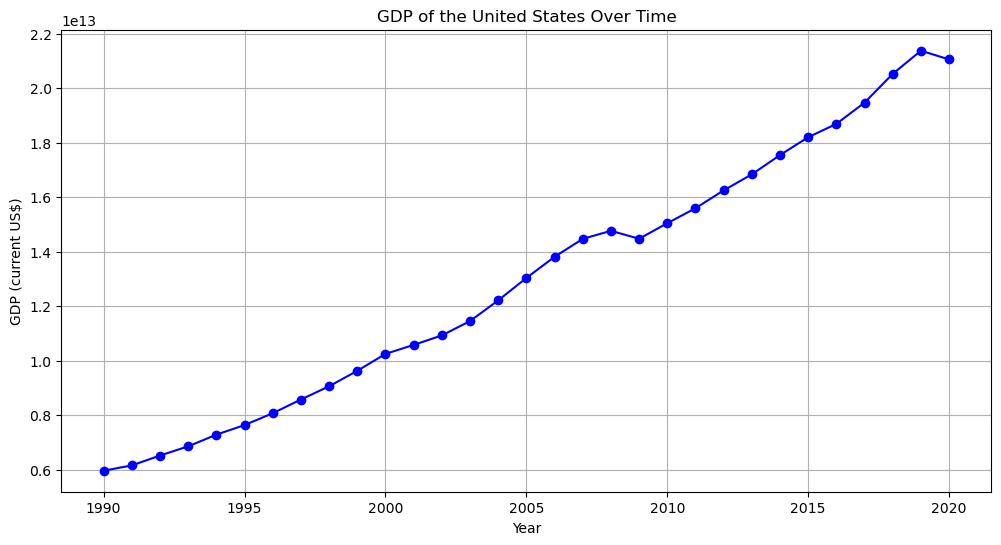

In [523]:

# Selecting data for the USA
usa_gdp_data = usa_gdp.loc[:,1990.0:]
usa_gdp_data
years = usa_gdp_data.columns

# Extracting the GDP values for the USA
gdp_values = usa_gdp_data.values.flatten()

# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(years, gdp_values, marker='o', linestyle='-', color='b')
plt.title('GDP of the United States Over Time')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.grid(True)
plt.show()

In [524]:
usa_gdp_data = usa_gdp.loc[:,1991.0:]
usa_gdp_data.shape

(1, 30)

In [525]:
gdp_values = usa_gdp_data.values.flatten()
gdp_values.shape

(30,)

In [526]:
type(usa_gdp_data)

pandas.core.frame.DataFrame

In [527]:
type(us_co2_data.values)

numpy.ndarray

In [528]:
us_co2_data.shape

(30,)

##Modeling

In [529]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Function to fit (linear model)
def linear_model(x, a, b):
    return a * x + b

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

#GDP DATA
usa_gdp_data = usa_gdp_data.values.flatten()[1:]
#CO2 DATA
us_co2_data_numpy = us_co2_data.values

In [530]:
def cubic_model(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

Parameters (a, b, c): [-1.47228970e-20  3.68267487e-07  3.27667030e+06]


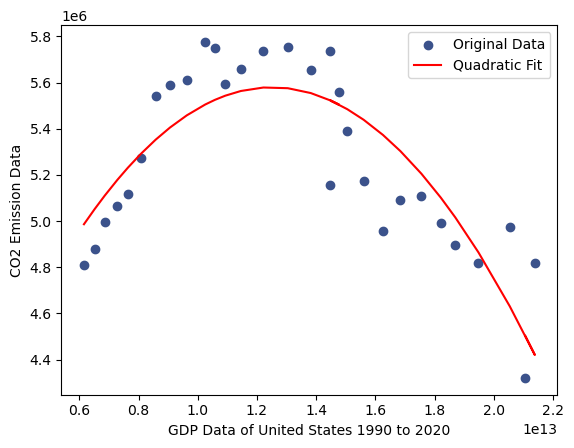

In [531]:
x_data = gdp_values
y_data = us_co2_data.values.flatten()



# Fit the quadratic model to the data
quad_params, quad_covariance = curve_fit(quadratic_model, x_data, y_data)

# Print the parameters
print('Parameters (a, b, c):', quad_params)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, quadratic_model(x_data, *quad_params), color='red', label='Quadratic Fit')
plt.xlabel('GDP Data of United States 1990 to 2020')
plt.ylabel('CO2 Emission Data')
plt.legend()
plt.show()

# CUBIC FIT

Parameters (a, b, c): [ 1.89830881e-33 -9.32287872e-20  1.37646549e-06 -6.76096195e+05]


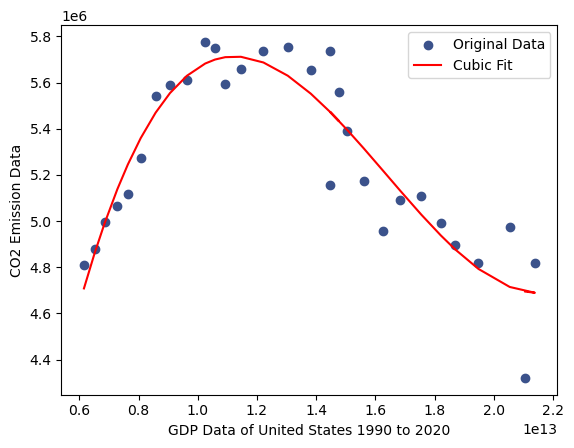

In [532]:
# Fit the quadratic model to the data
cubic_params, cubic_covariance  = curve_fit(cubic_model, x_data, y_data)

# Print the parameters
print('Parameters (a, b, c):', cubic_params)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, cubic_model(x_data, *cubic_params), color='red', label='Cubic Fit')
plt.xlabel('GDP Data of United States 1990 to 2020')
plt.ylabel('CO2 Emission Data')
plt.legend()
plt.show()

FOURTH DEGREE FIT

In [533]:
def fourth_degree_model(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e


Parameters (a, b, c): [ 2.10906420e-47  7.43032441e-34 -7.06429884e-20  1.19093406e-06
 -1.38920797e+05]


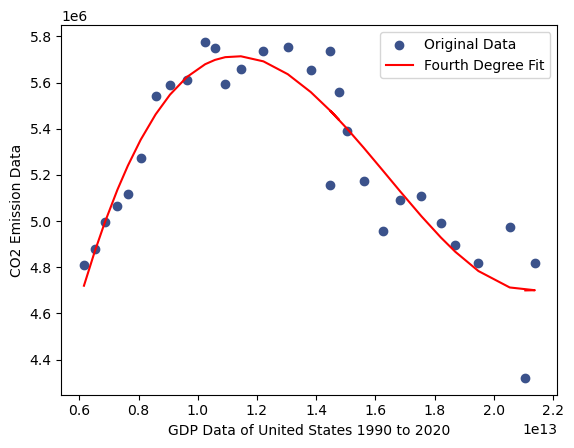

In [534]:
# Fit the quadratic model to the data
fourth_params, fourth_covariance = curve_fit(fourth_degree_model, x_data, y_data)

# Print the parameters
print('Parameters (a, b, c):', fourth_params)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, fourth_degree_model(x_data, *fourth_params), color='red', label='Fourth Degree Fit')
plt.xlabel('GDP Data of United States 1990 to 2020')
plt.ylabel('CO2 Emission Data')
plt.legend()
plt.show()

#ERROR RANGES

## functions

In [535]:
"""
Module errors. Contains:
error_prop Calculates the error range caused by the uncertainty of the fit
    parameters. Covariances are taken into account.
cover_to_corr: Converts covariance matrix into correlation matrix.
"""


import numpy as np


def error_prop(x, func, parameter, covar):
    """
    Calculates 1 sigma error ranges for number or array. It uses error
    propagation with variances and covariances taken from the covar matrix.
    Derivatives are calculated numerically.

    """

    # initiate sigma the same shape as parameter

    var = np.zeros_like(x)   # initialise variance vektor
    # Nested loop over all combinations of the parameters
    for i in range(len(parameter)):
        # derivative with respect to the ith parameter
        deriv1 = deriv(x, func, parameter, i)

        for j in range(len(parameter)):
            # derivative with respct to the jth parameter
            deriv2 = deriv(x, func, parameter, j)



            # multiplied with the i-jth covariance
            # variance vektor
            var = var + deriv1*deriv2*covar[i, j]

    sigma = np.sqrt(var)
    return sigma


def deriv(x, func, parameter, ip):
    """
    Calculates numerical derivatives from function
    values at parameter +/- delta.  Parameter is the vector with parameter
    values. ip is the index of the parameter to derive the derivative.

    """

    # print("in", ip, parameter[ip])
    # create vector with zeros and insert delta value for relevant parameter
    # delta is calculated as a small fraction of the parameter value
    scale = 1e-6   # scale factor to calculate the derivative
    delta = np.zeros_like(parameter, dtype=float)
    val = scale * np.abs(parameter[ip])
    delta[ip] = val  #scale * np.abs(parameter[ip])

    diff = 0.5 * (func(x, *parameter+delta) - func(x, *parameter-delta))
    dfdx = diff / val

    return dfdx


def covar_to_corr(covar):
    """ Converts the covariance matrix into a correlation matrix """

    # extract variances from the diagonal and calculate std. dev.
    sigma = np.sqrt(np.diag(covar))
    # construct matrix containing the sigma values
    matrix = np.outer(sigma, sigma)
    # and divide by it
    corr = covar/matrix

    return corr



## ERROR FUNCTIONS USE

In [536]:
# Calculate error ranges using the provided functions
error_ranges_quadratic = error_prop(x_data, quadratic_model, quad_params, quad_covariance)
error_ranges_cubic= error_prop(x_data, cubic_model, cubic_params, cubic_covariance)
error_ranges_fourth = error_prop(x_data, fourth_degree_model, fourth_params, fourth_covariance)

# Print the error ranges
print(f"Error Ranges Quadratic:{error_ranges_quadratic}\n\n")
print(f"Error Ranges cubic:{error_ranges_cubic}\n\n" )
print(f"Error Ranges fourth:{error_ranges_fourth}\n\n")


Error Ranges Quadratic:[ 97936.22819884  89040.31852424  81471.54074112  72973.39519082
  66962.81372361  60857.14574584  55598.74757246  52389.17677399
  50689.34760039  50777.49500863  51381.19917899  52262.25766561
  53826.61997395  55997.85550378  57607.82786939  58104.63231413
  57717.28258711  57331.79188217  57713.04044595  56872.01285044
  55788.6775149   54507.62184173  53834.99030632  54464.51399899
  57314.04538632  61275.35904184  71217.47797291  91492.43720653
 112880.91603514 104301.45311527]


Error Ranges cubic:[89155.2647906  74220.69140503 63123.05276896 53160.08669536
 48322.05147825 45868.49492912 46167.23074668 47768.70996218
 49589.03544194 50491.44142105 50394.19940185 49881.64358145
 48445.13262895 45603.23579404 42839.07434131 41864.95249449
 42753.99199025 43611.65045594 42763.52409528 44613.59610861
 46901.18240042 49594.1905182  51445.16949352 52472.71163842
 52279.39256398 51887.32648897 53193.11930523 67916.13252559
 96964.51047497 84057.21486713]


Error 

In [537]:
!pip install uncertainties

In [538]:
from uncertainties import ufloat

quad_sigma_ab = np.sqrt(np.diagonal(quad_covariance))
cubic_sigma_ab = np.sqrt(np.diagonal(cubic_covariance))
fourth_sigma_ab = np.sqrt(np.diagonal(fourth_covariance))

quad_a = ufloat(quad_params[0], quad_sigma_ab[0])
quad_b = ufloat(quad_params[1], quad_sigma_ab[1])
text_res = f"Best fit parameters for Quadratic Function:\na = {quad_a}\nb = {quad_b}"
print(text_res)

Best fit parameters for Quadratic Function:
a = (-1.47+/-0.20)e-20
b = (3.7+/-0.6)e-07


In [539]:
cubic_a = ufloat(cubic_params[0], cubic_sigma_ab[0])
cubic_b = ufloat(cubic_params[1], cubic_sigma_ab[1])
cubic_c = ufloat(cubic_params[2], cubic_sigma_ab[2])

text_res = f"Best fit parametersfor Cubic Function:\na = {cubic_a}\nb = {cubic_b}\nc = {cubic_c}"
print(text_res)

Best fit parametersfor Cubic Function:
a = (1.9+/-0.4)e-33
b = (-9.3+/-1.5)e-20
c = (1.38+/-0.20)e-06


In [540]:
fourth_a = ufloat(fourth_params[0], fourth_sigma_ab[0])
fourth_b = ufloat(fourth_params[1], fourth_sigma_ab[1])
fourth_c = ufloat(fourth_params[2], cubic_sigma_ab[2])
fourth_d = ufloat(fourth_params[3], cubic_sigma_ab[3])
text_res = f"Best fit parameters for Fourth Function:\na = {fourth_a}\nb = {fourth_b}\nc = {fourth_c}\nd = {fourth_d}"
print(text_res)

Best fit parameters for Fourth Function:
a = (0.2+/-1.0)e-46
b = (1+/-5)e-33
c = (-0.0+/-2.0)e-07
d = (0+/-8)e+05


###Box plots

In [541]:
# # Create boxplot

# x_fit = x_data
# y_fit = cubic_model(x_data, *cubic_params)

# plt.boxplot([y_fit], positions=[1], labels=['Cubic Fit'], showfliers=False)
# # plt.scatter(np.ones(len(years)), co2_emissions, color='blue', label='Data', zorder=10)

# # Adding labels and title
# plt.xlabel('Fit Models')
# plt.ylabel('CO2 Emissions')
# plt.title('Boxplot of Cubic Fit Model with Best Fit Parameters and Data')

# # Display legend
# plt.legend()

# # Display the plot
# plt.show()

###Correlation matrix

In [115]:
# Convert covariance matrix to correlation matrix
quad_corr_matrix = covar_to_corr(quad_covariance)
cubic_corr_matrix = covar_to_corr(cubic_covariance)
fourth_corr_matrix = covar_to_corr(fourth_covariance)
print("Correlation Matrix:")
print(f"{quad_corr_matrix}\n\n")
print(f"{cubic_corr_matrix}\n\n")
print(f"{fourth_corr_matrix}\n\n")


Correlation Matrix:
[[ 1.         -0.98829995  0.94072277]
 [-0.98829995  1.         -0.97856637]
 [ 0.94072277 -0.97856637  1.        ]]


[[ 1.         -0.99557211  0.98026376 -0.95138725]
 [-0.99557211  1.         -0.99428926  0.97441045]
 [ 0.98026376 -0.99428926  1.         -0.99219461]
 [-0.95138725  0.97441045 -0.99219461  1.        ]]


[[ 1.         -0.99758436  0.98923103 -0.97349789  0.95025803]
 [-0.99758436  1.         -0.99696351  0.98671919 -0.96854672]
 [ 0.98923103 -0.99696351  1.         -0.99629568  0.9844448 ]
 [-0.97349789  0.98671919 -0.99629568  1.         -0.99574872]
 [ 0.95025803 -0.96854672  0.9844448  -0.99574872  1.        ]]


